# Chayanin Kongsareekul 6532035021

# Q1: How many hackers are trying to get access to our servers? And how many attempts are there? Explain/define how you count distinct hackers.

In [ ]:
source="tutorialdata.zip:*" "Failed password"
| rex field=_raw "from (?<src_ip>\d+\.\d+\.\d+\.\d+)"
| stats dc(src_ip) as unique_hackers, count as total_attempts
| eval summary="Total Hackers: " + tostring(unique_hackers) + " | Total Attempts: " + tostring(total_attempts)

## 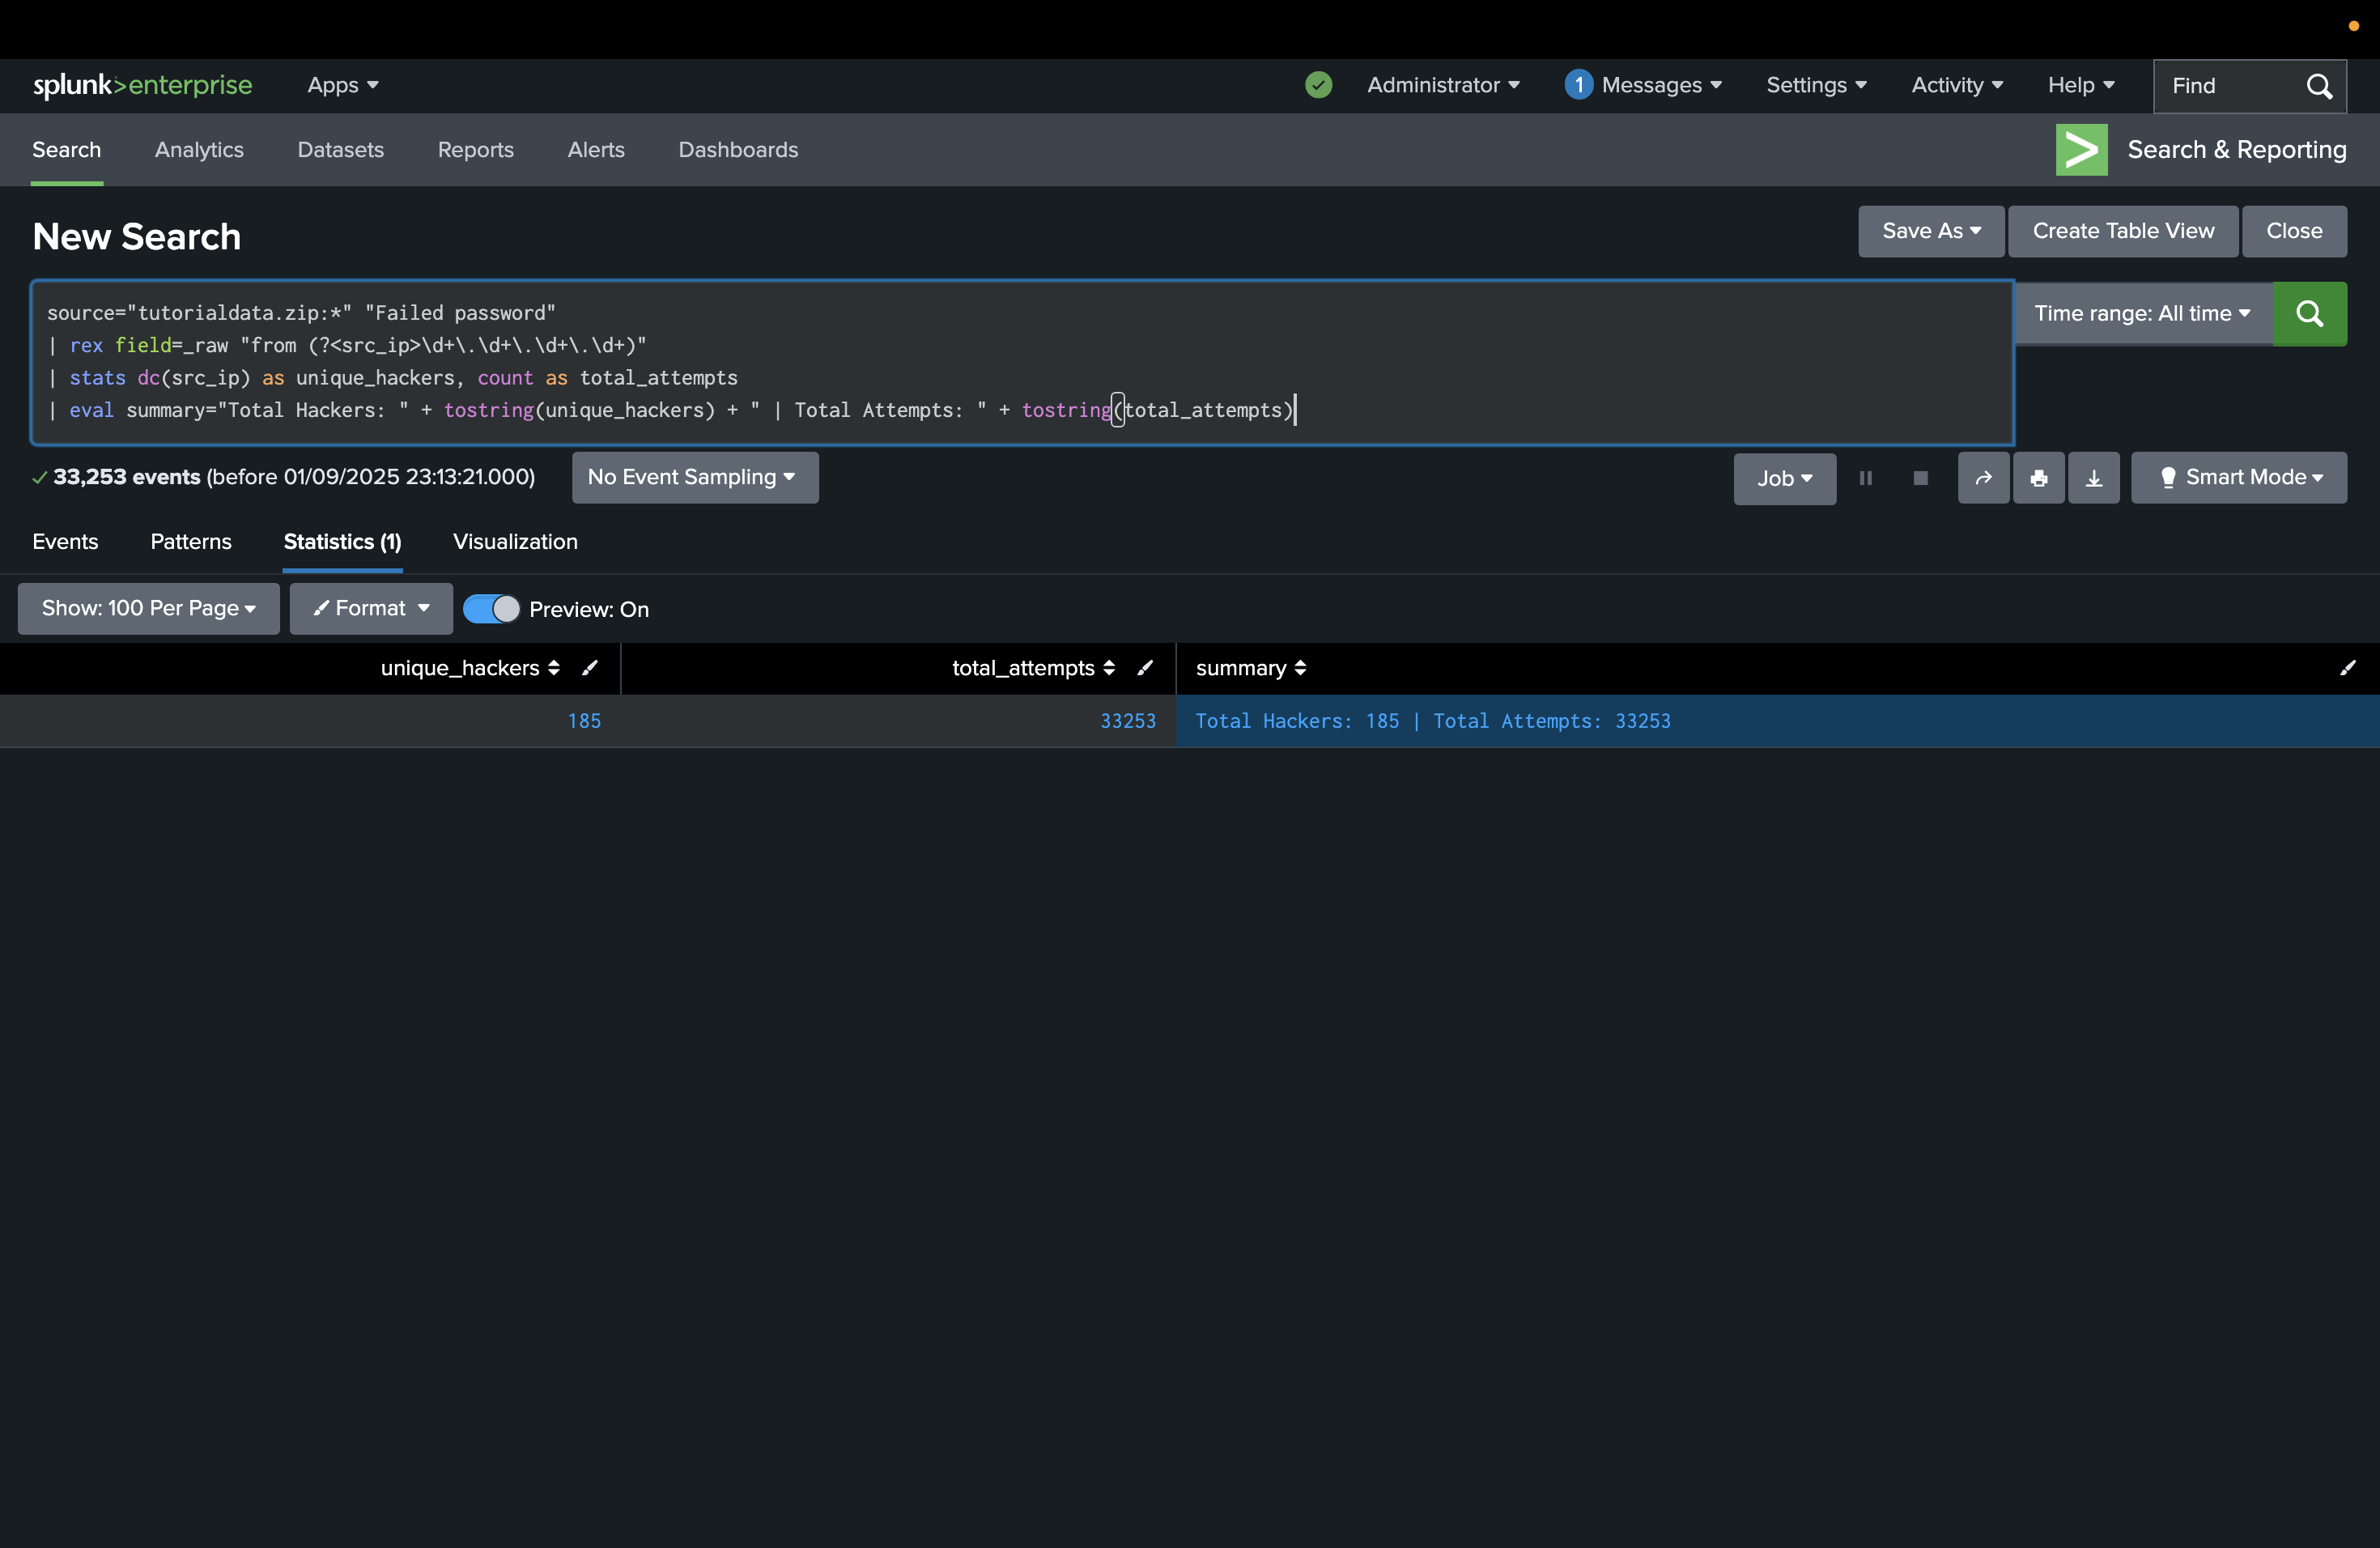

## Answer:
#### Total Attempts: 33253
#### Distinct Hackers: 185

#### The query searches for "Failed password" entries and extracts source IP addresses using regex. Distinct hackers are defined as unique IP addresses, assuming each IP represents a different attacker. This identified 185 unique attacking IPs with 33,253 total failed login attempts, averaging ~180 attempts per IP.

# Q2: What time do hackers appear to try to hack our servers?

In [ ]:
source="tutorialdata.zip:*" "Failed password"
| eval timestamp=strftime(_time, "%Y/%m/%d %H:%M:%S")
| stats count as attempts by timestamp
| sort timestamp

## 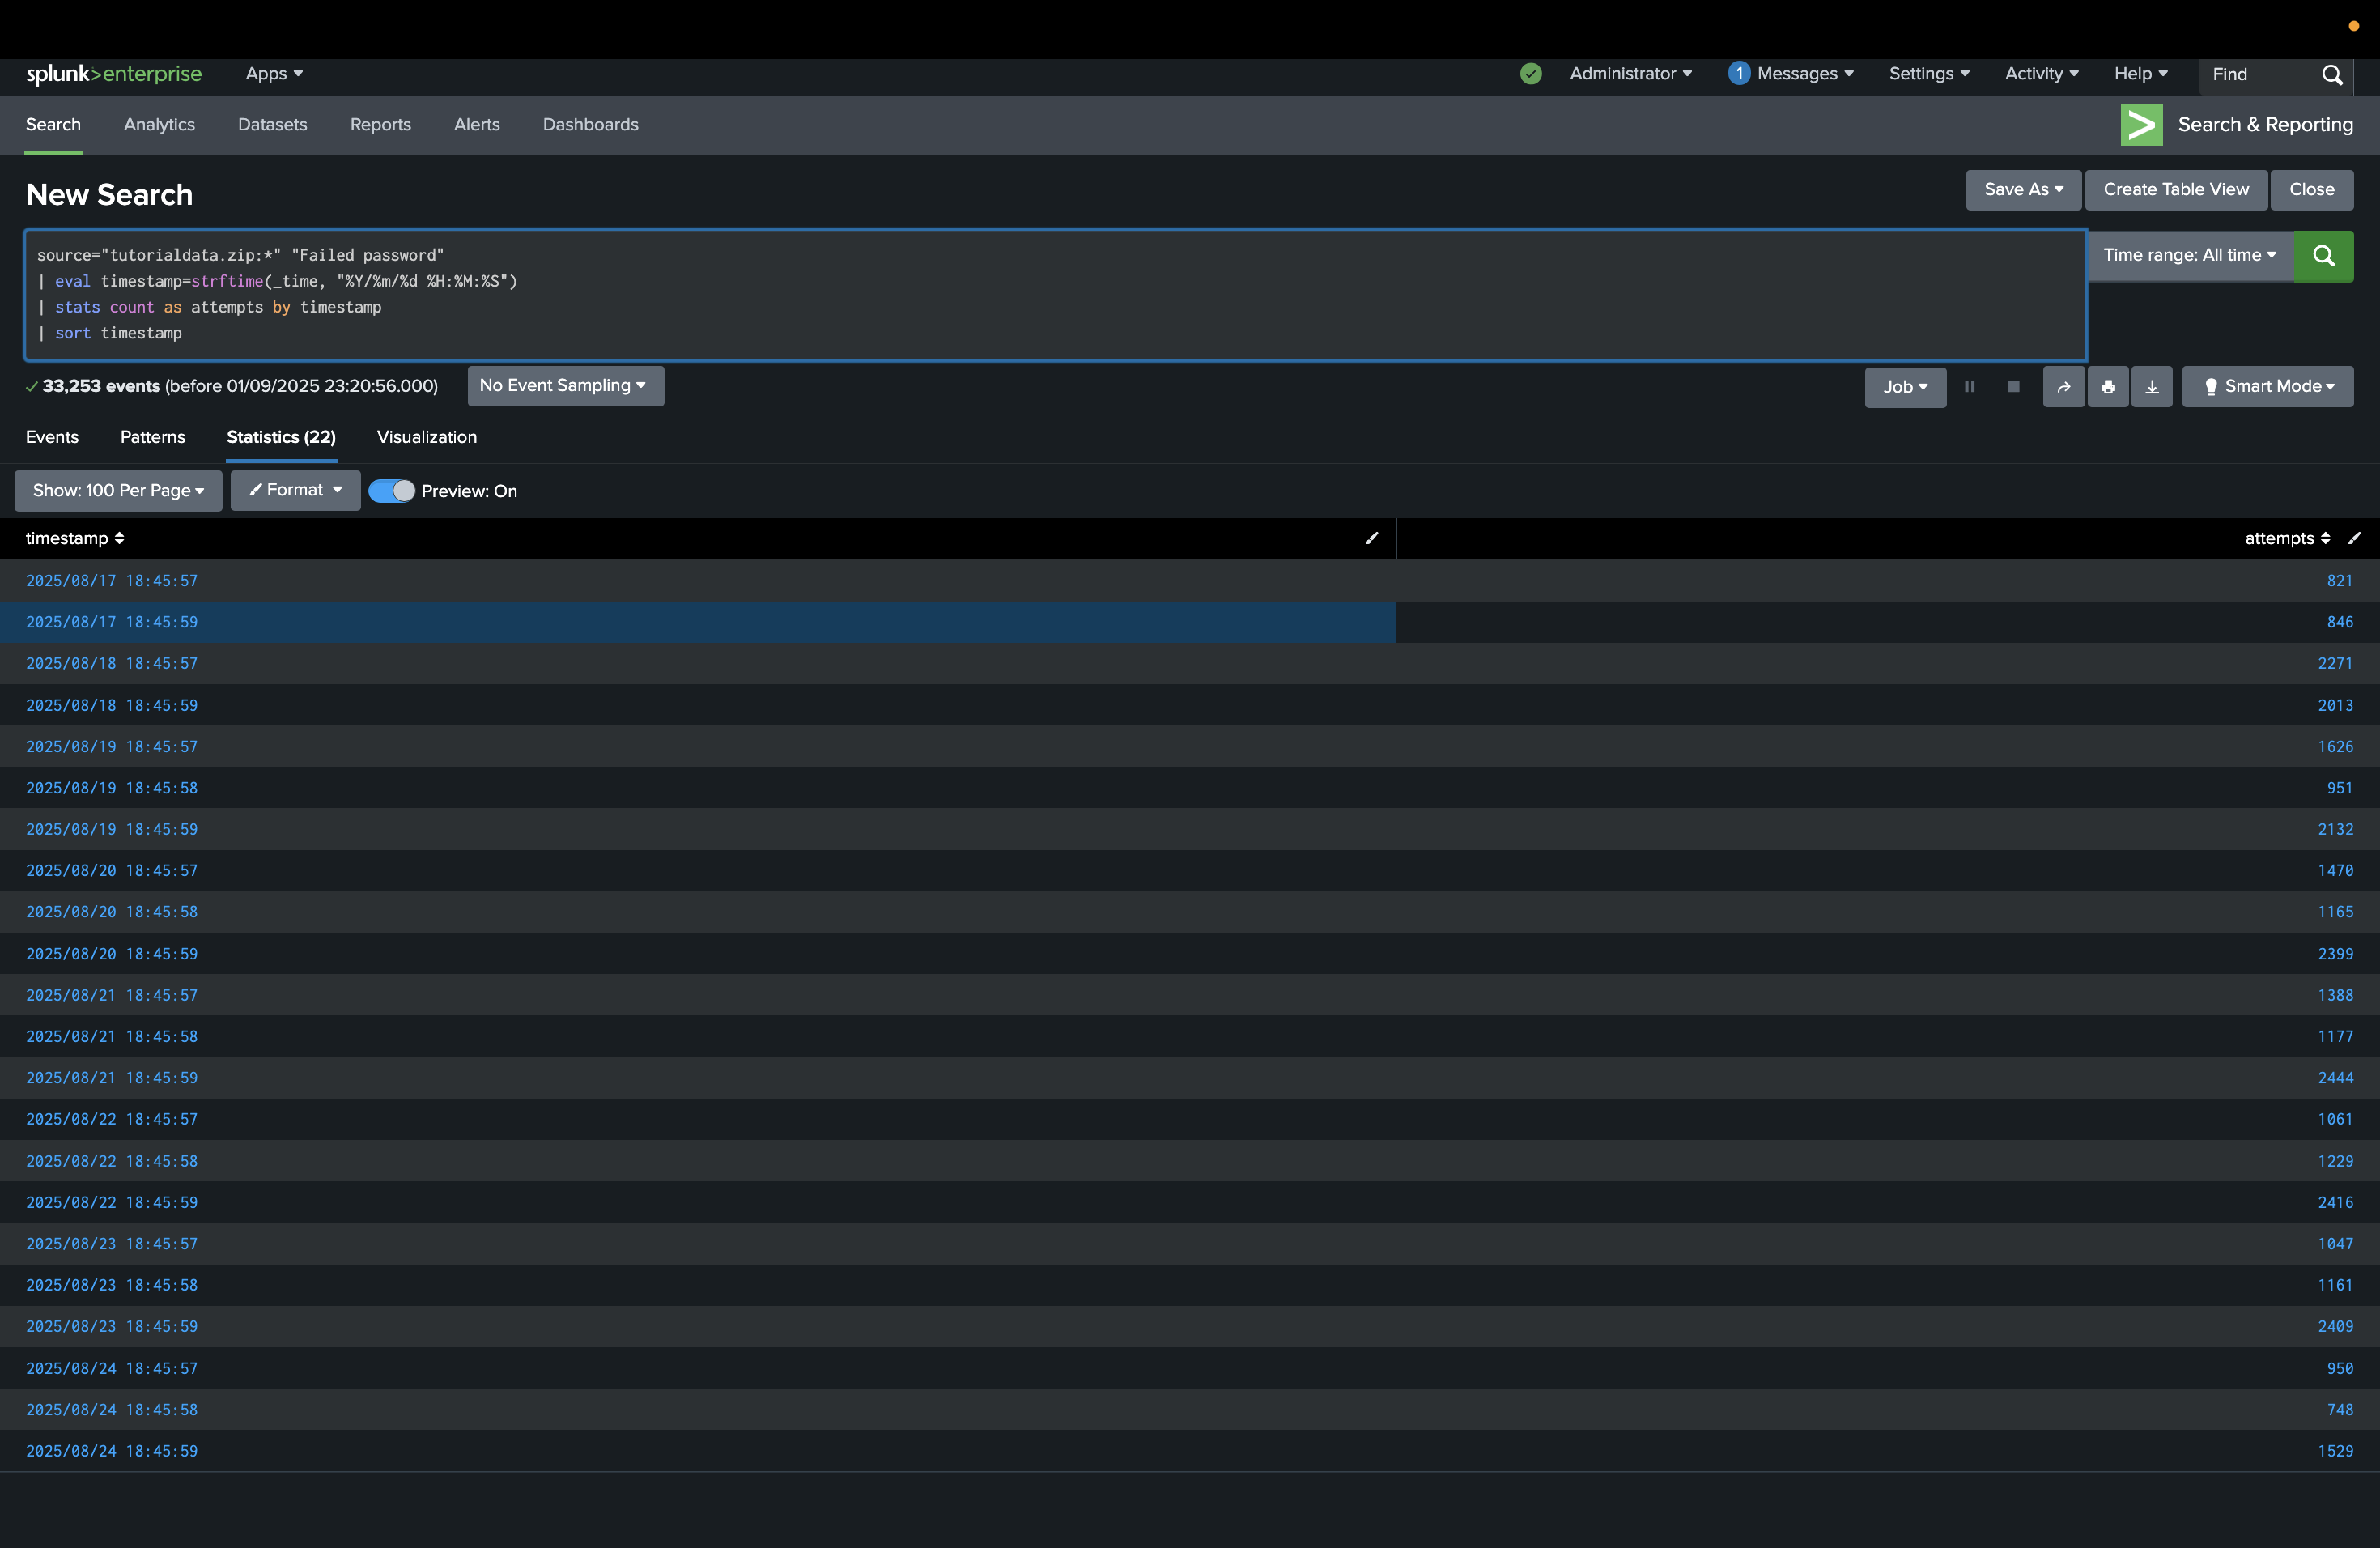

## Answer:
#### The query groups failed password attempts by timestamp to identify attack timing patterns. Hackers consistently attack around 18:45:57 - 18:45:59 daily from August 17-24. The precise timing within seconds 57-59 of each minute indicates automated/scripted attacks rather than manual attempts.

# Q3: Which server (mailsv, www1, www2, www3) had the most attempts?

In [ ]:
source="tutorialdata.zip:*" "Failed password"
| rex field=_raw "^\w+\s+\w+\s+\d+\s+\d+\s+\d+:\d+:\d+\s+(?<server>\w+)"
| stats count as attempts by server
| sort -attempts

## 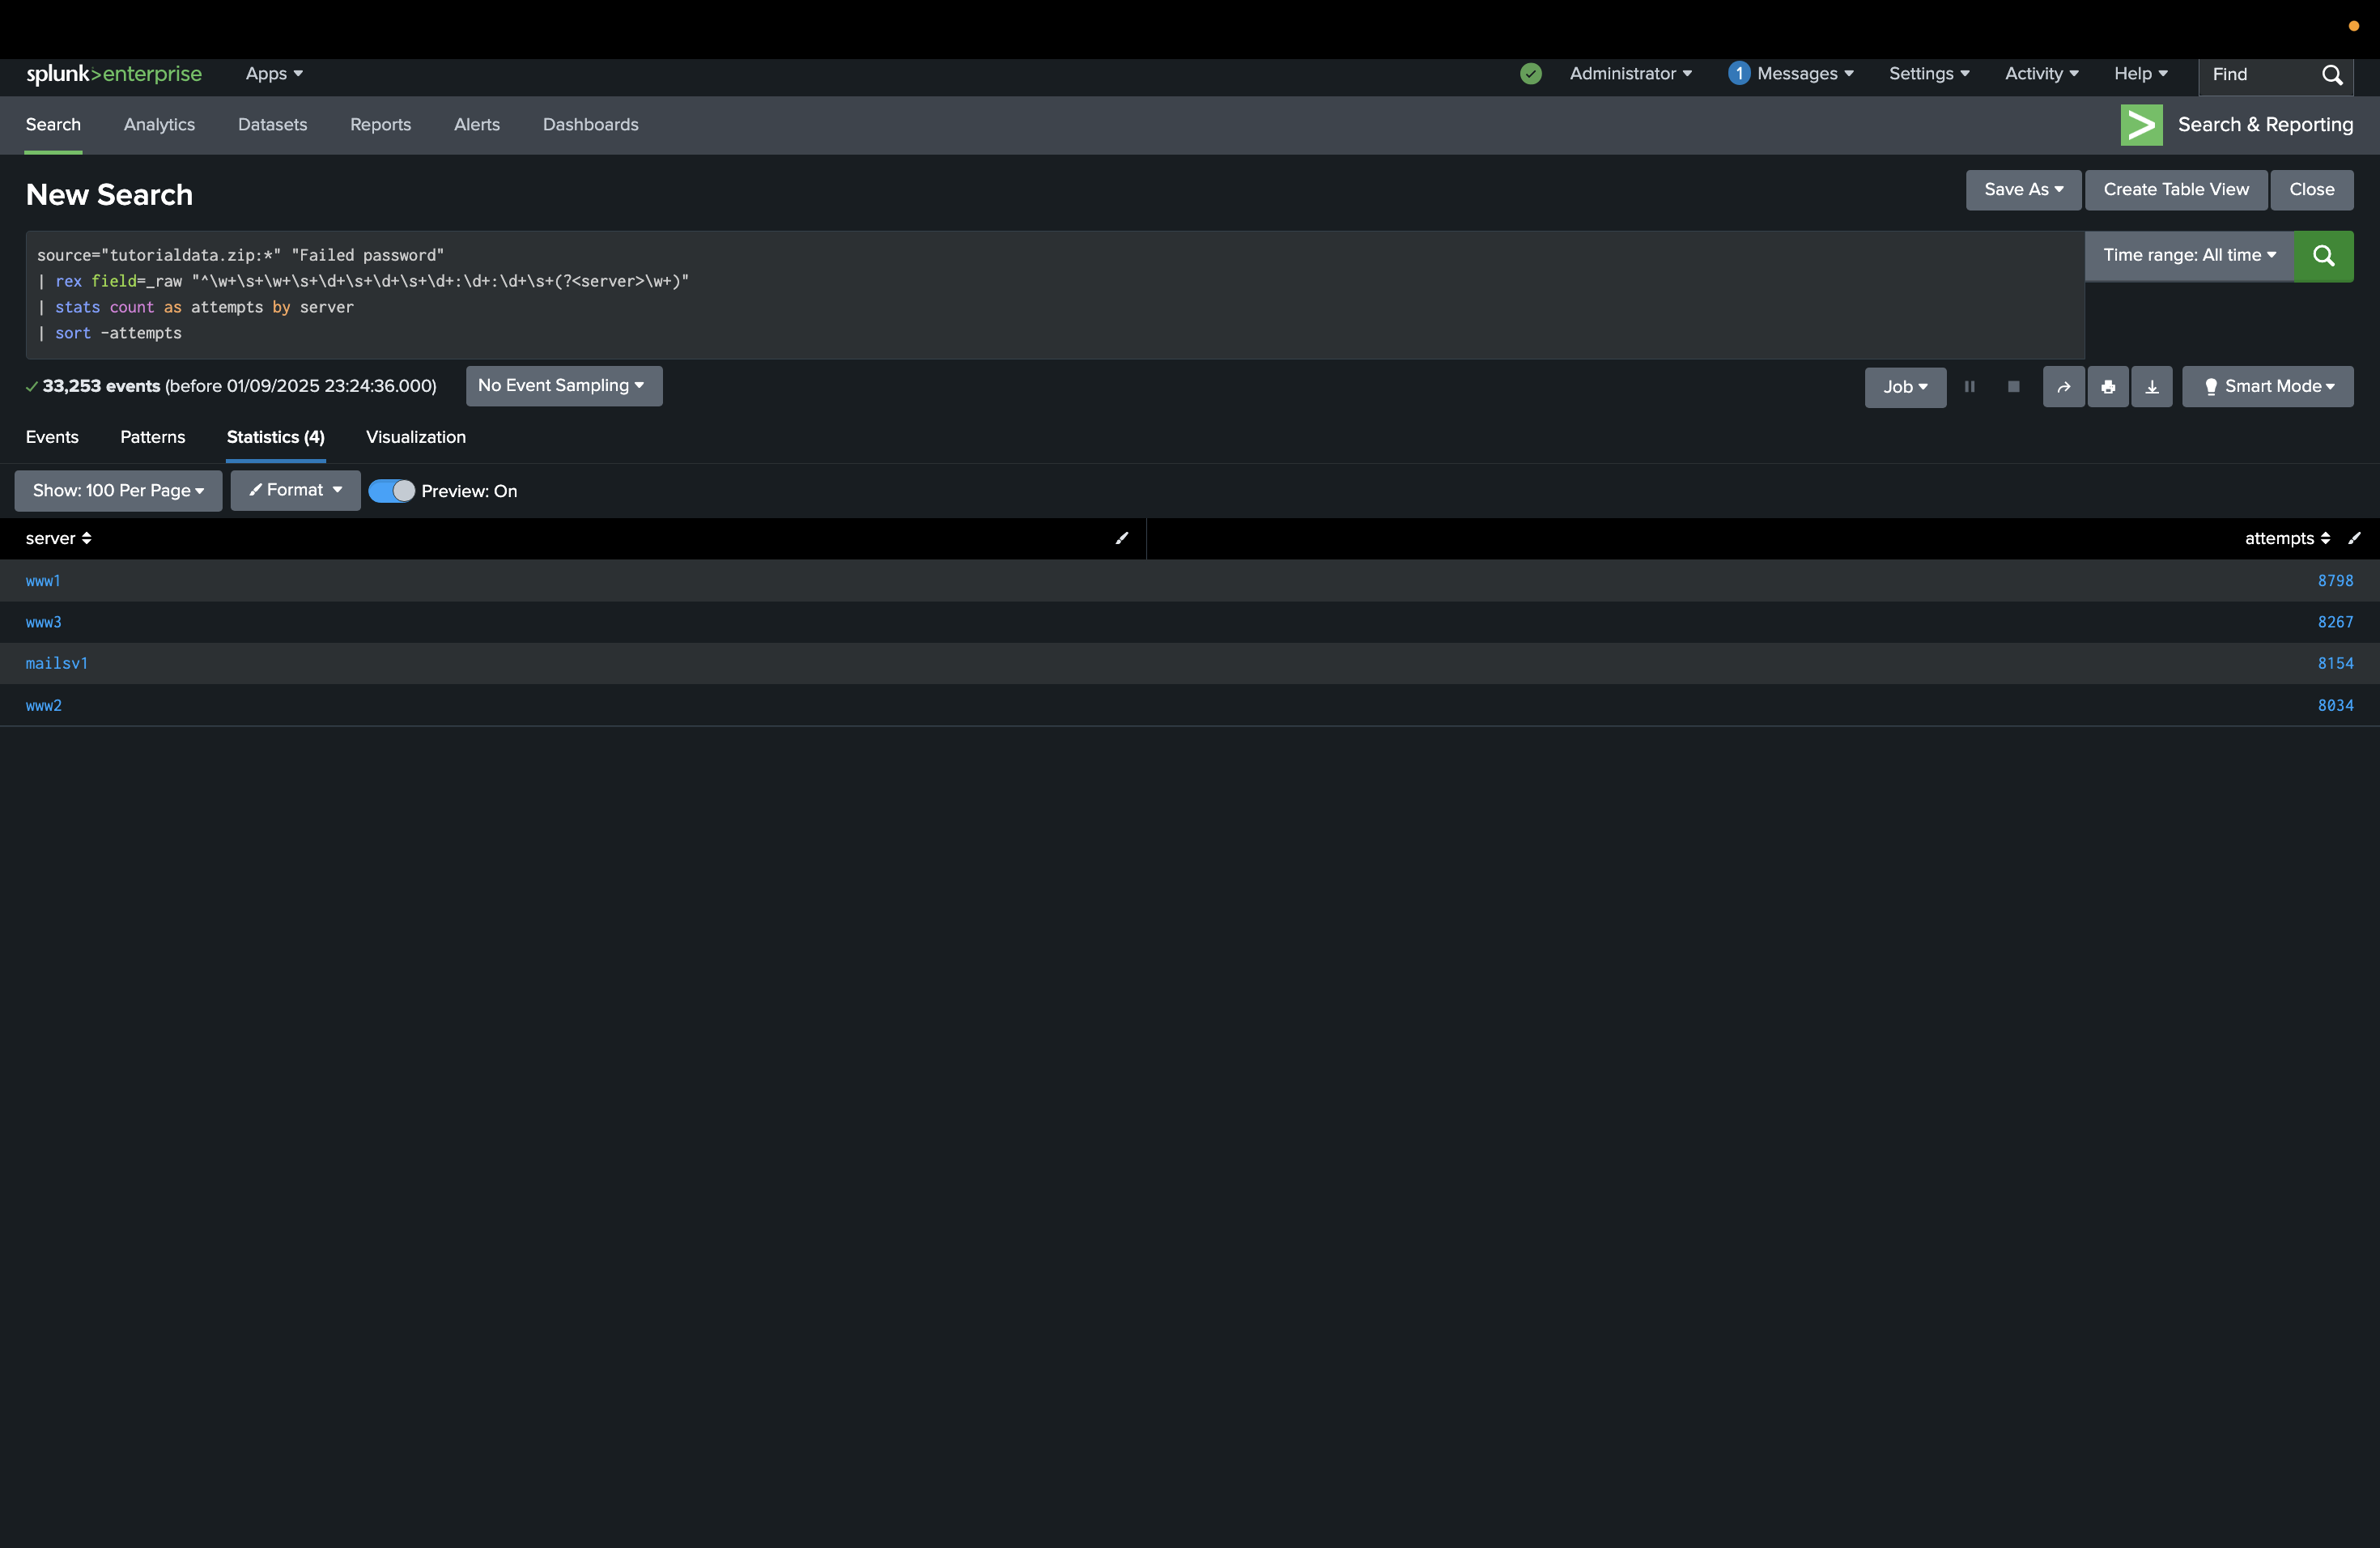

## Answer:
#### www1: 8,798 attempts

#### The query extracts server names using regex and counts failed password attempts per server.

# Q4: What is the most popular account that hackers use to try to break in?

In [ ]:
source="tutorialdata.zip:*" "Failed password"
| rex field=_raw "Failed password for (?:invalid user )?(?<target_user>\w+)"
| stats count as attempts by target_user
| sort -attempts

## 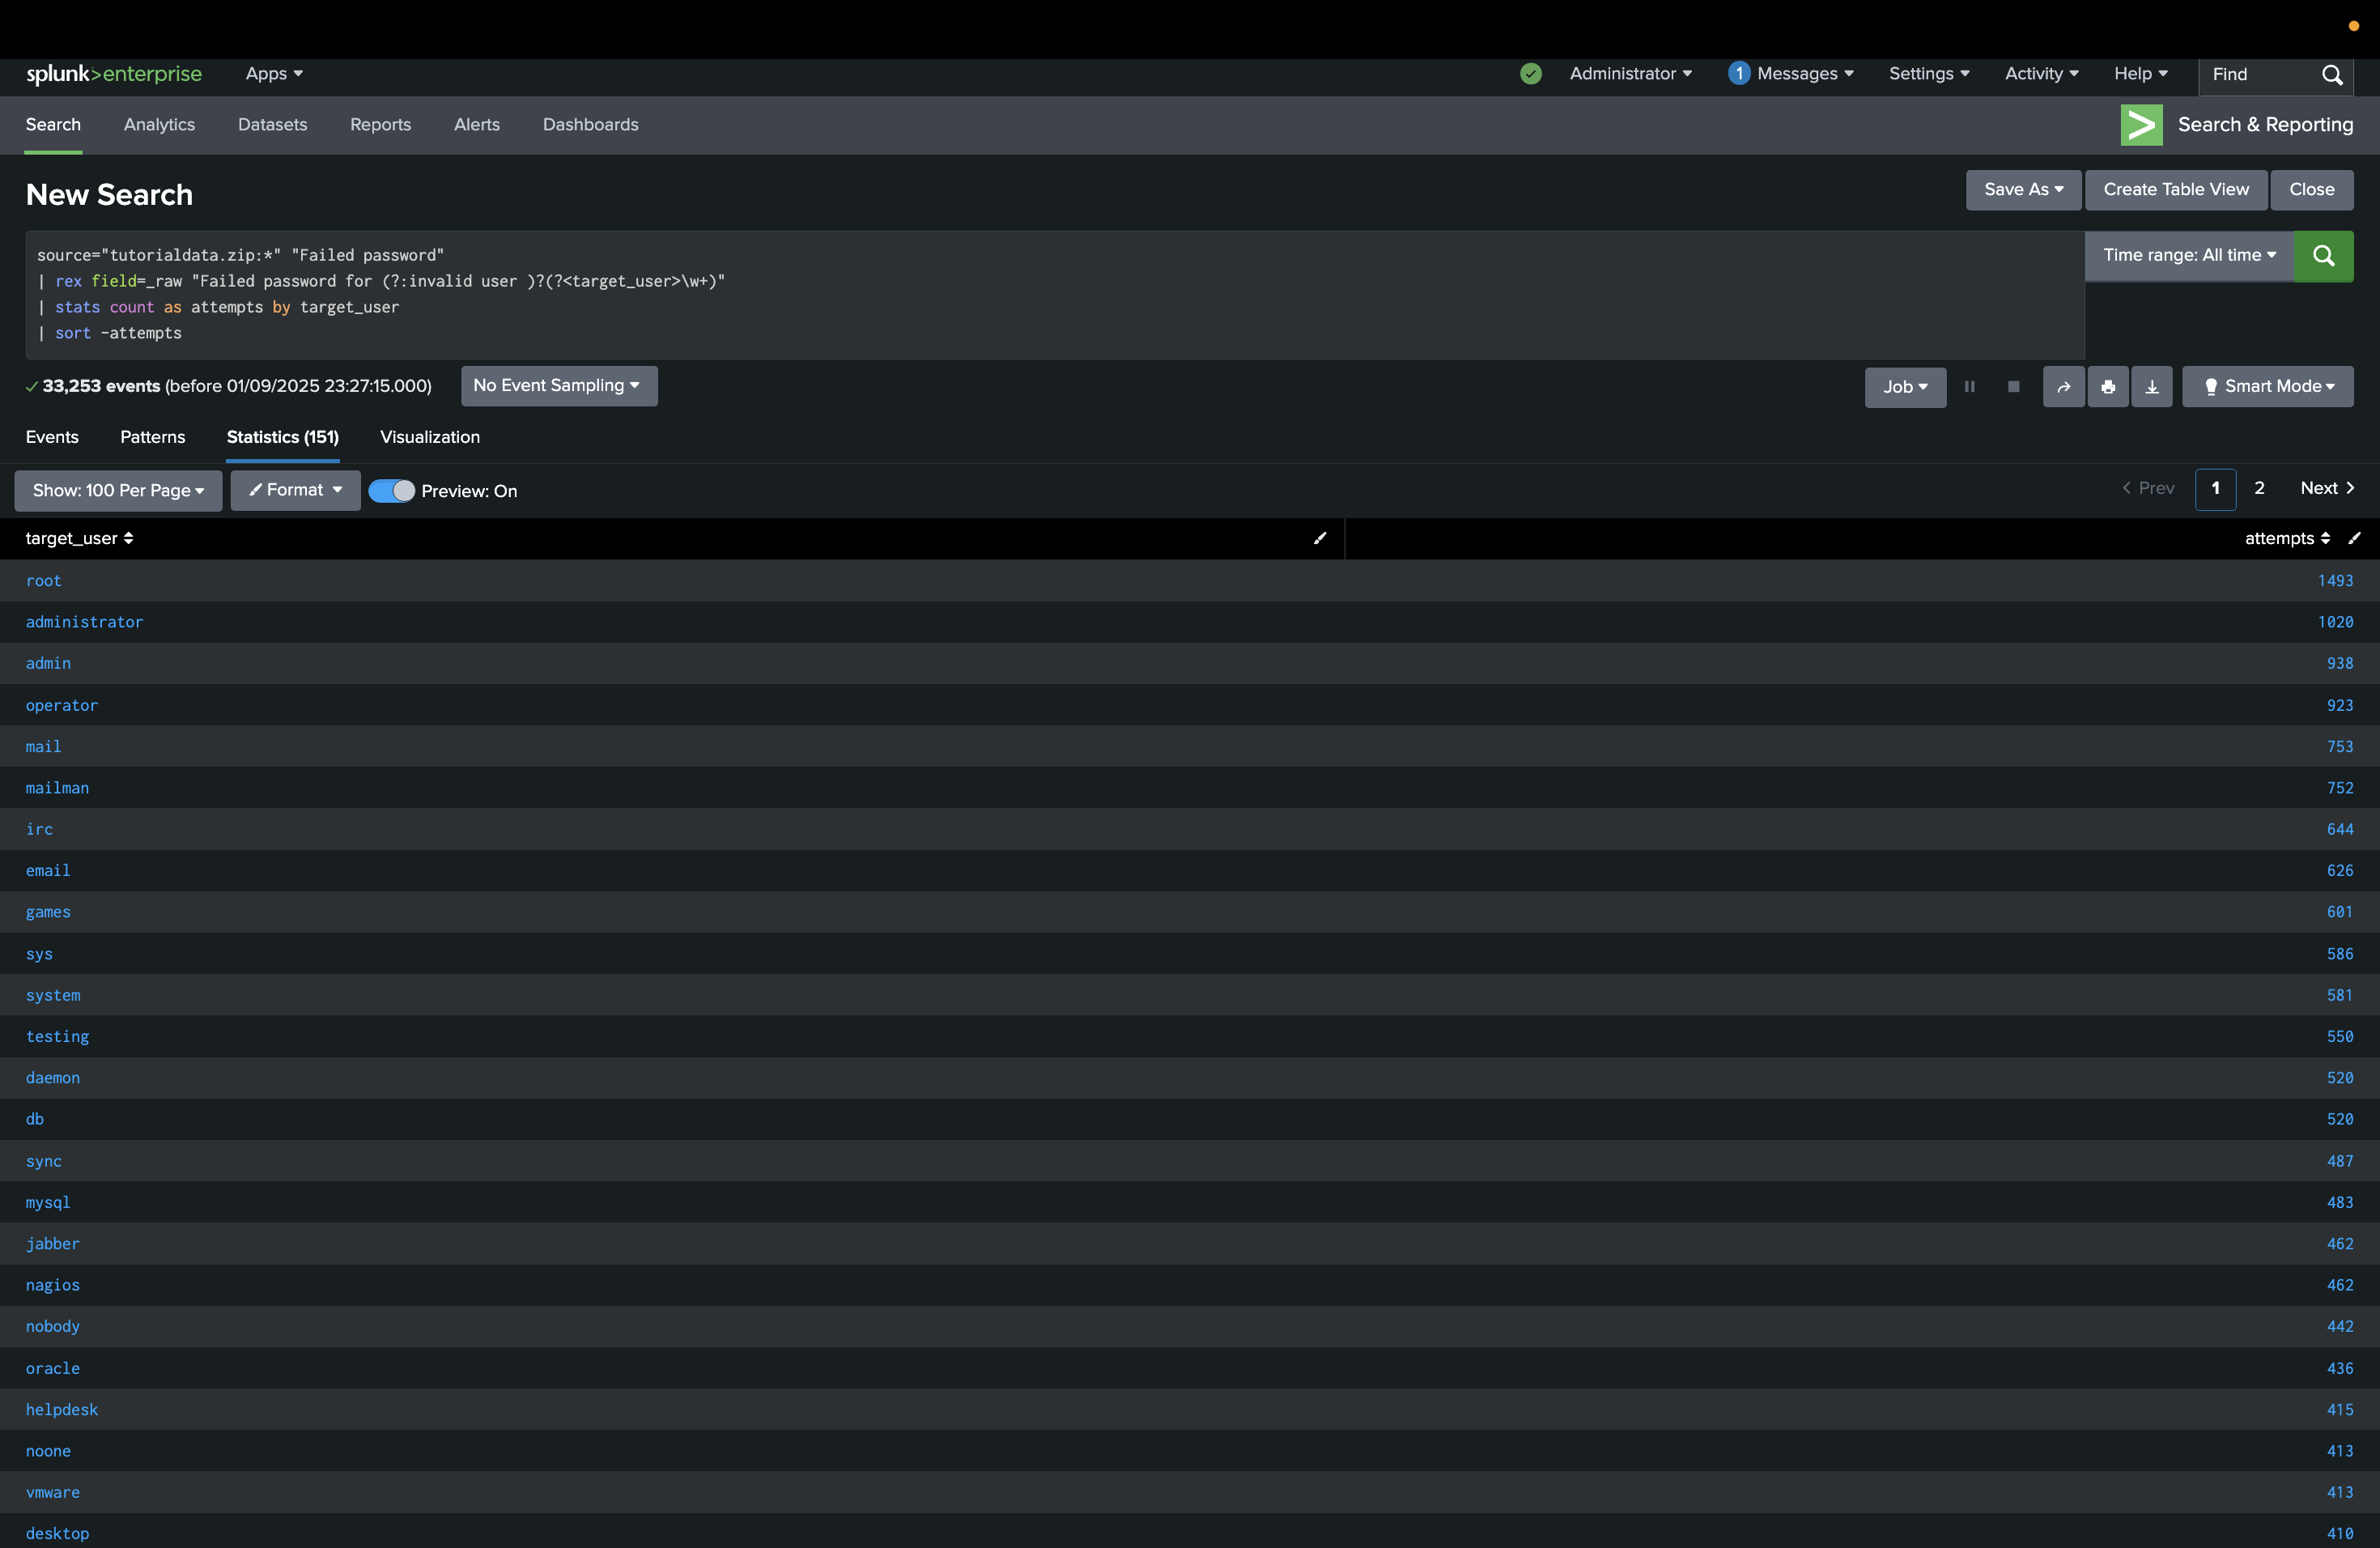

## Answer:
#### root: 1,493 attempts
#### The query extracts target usernames from failed password attempts using regex to capture both regular and "invalid user" entries. "root" is the most popular target account with 1,493 attempts.

# Q5: Can you find attempts to get access to sensitive information from our web servers? How many attempts were there?

In [ ]:
index=* (status=404 OR status=403 OR status=500 OR status=401 OR status=406) 
| rex field=_raw "\"(?<method>\w+)\s+(?<url>[^\s]+)" 
| rex field=_raw "\"\s+(?<status>\d+)\s+"
| eval clean_url = replace(url, "\?.*", "")
| where (strftime(_time, "%Y/%m/%d %H:%M:%S") >= "2025/08/17 18:45:57" AND strftime(_time, "%Y/%m/%d %H:%M:%S") <= "2025/08/24 18:45:59")
| stats count as total_attempts by clean_url
| sort -total_attempts

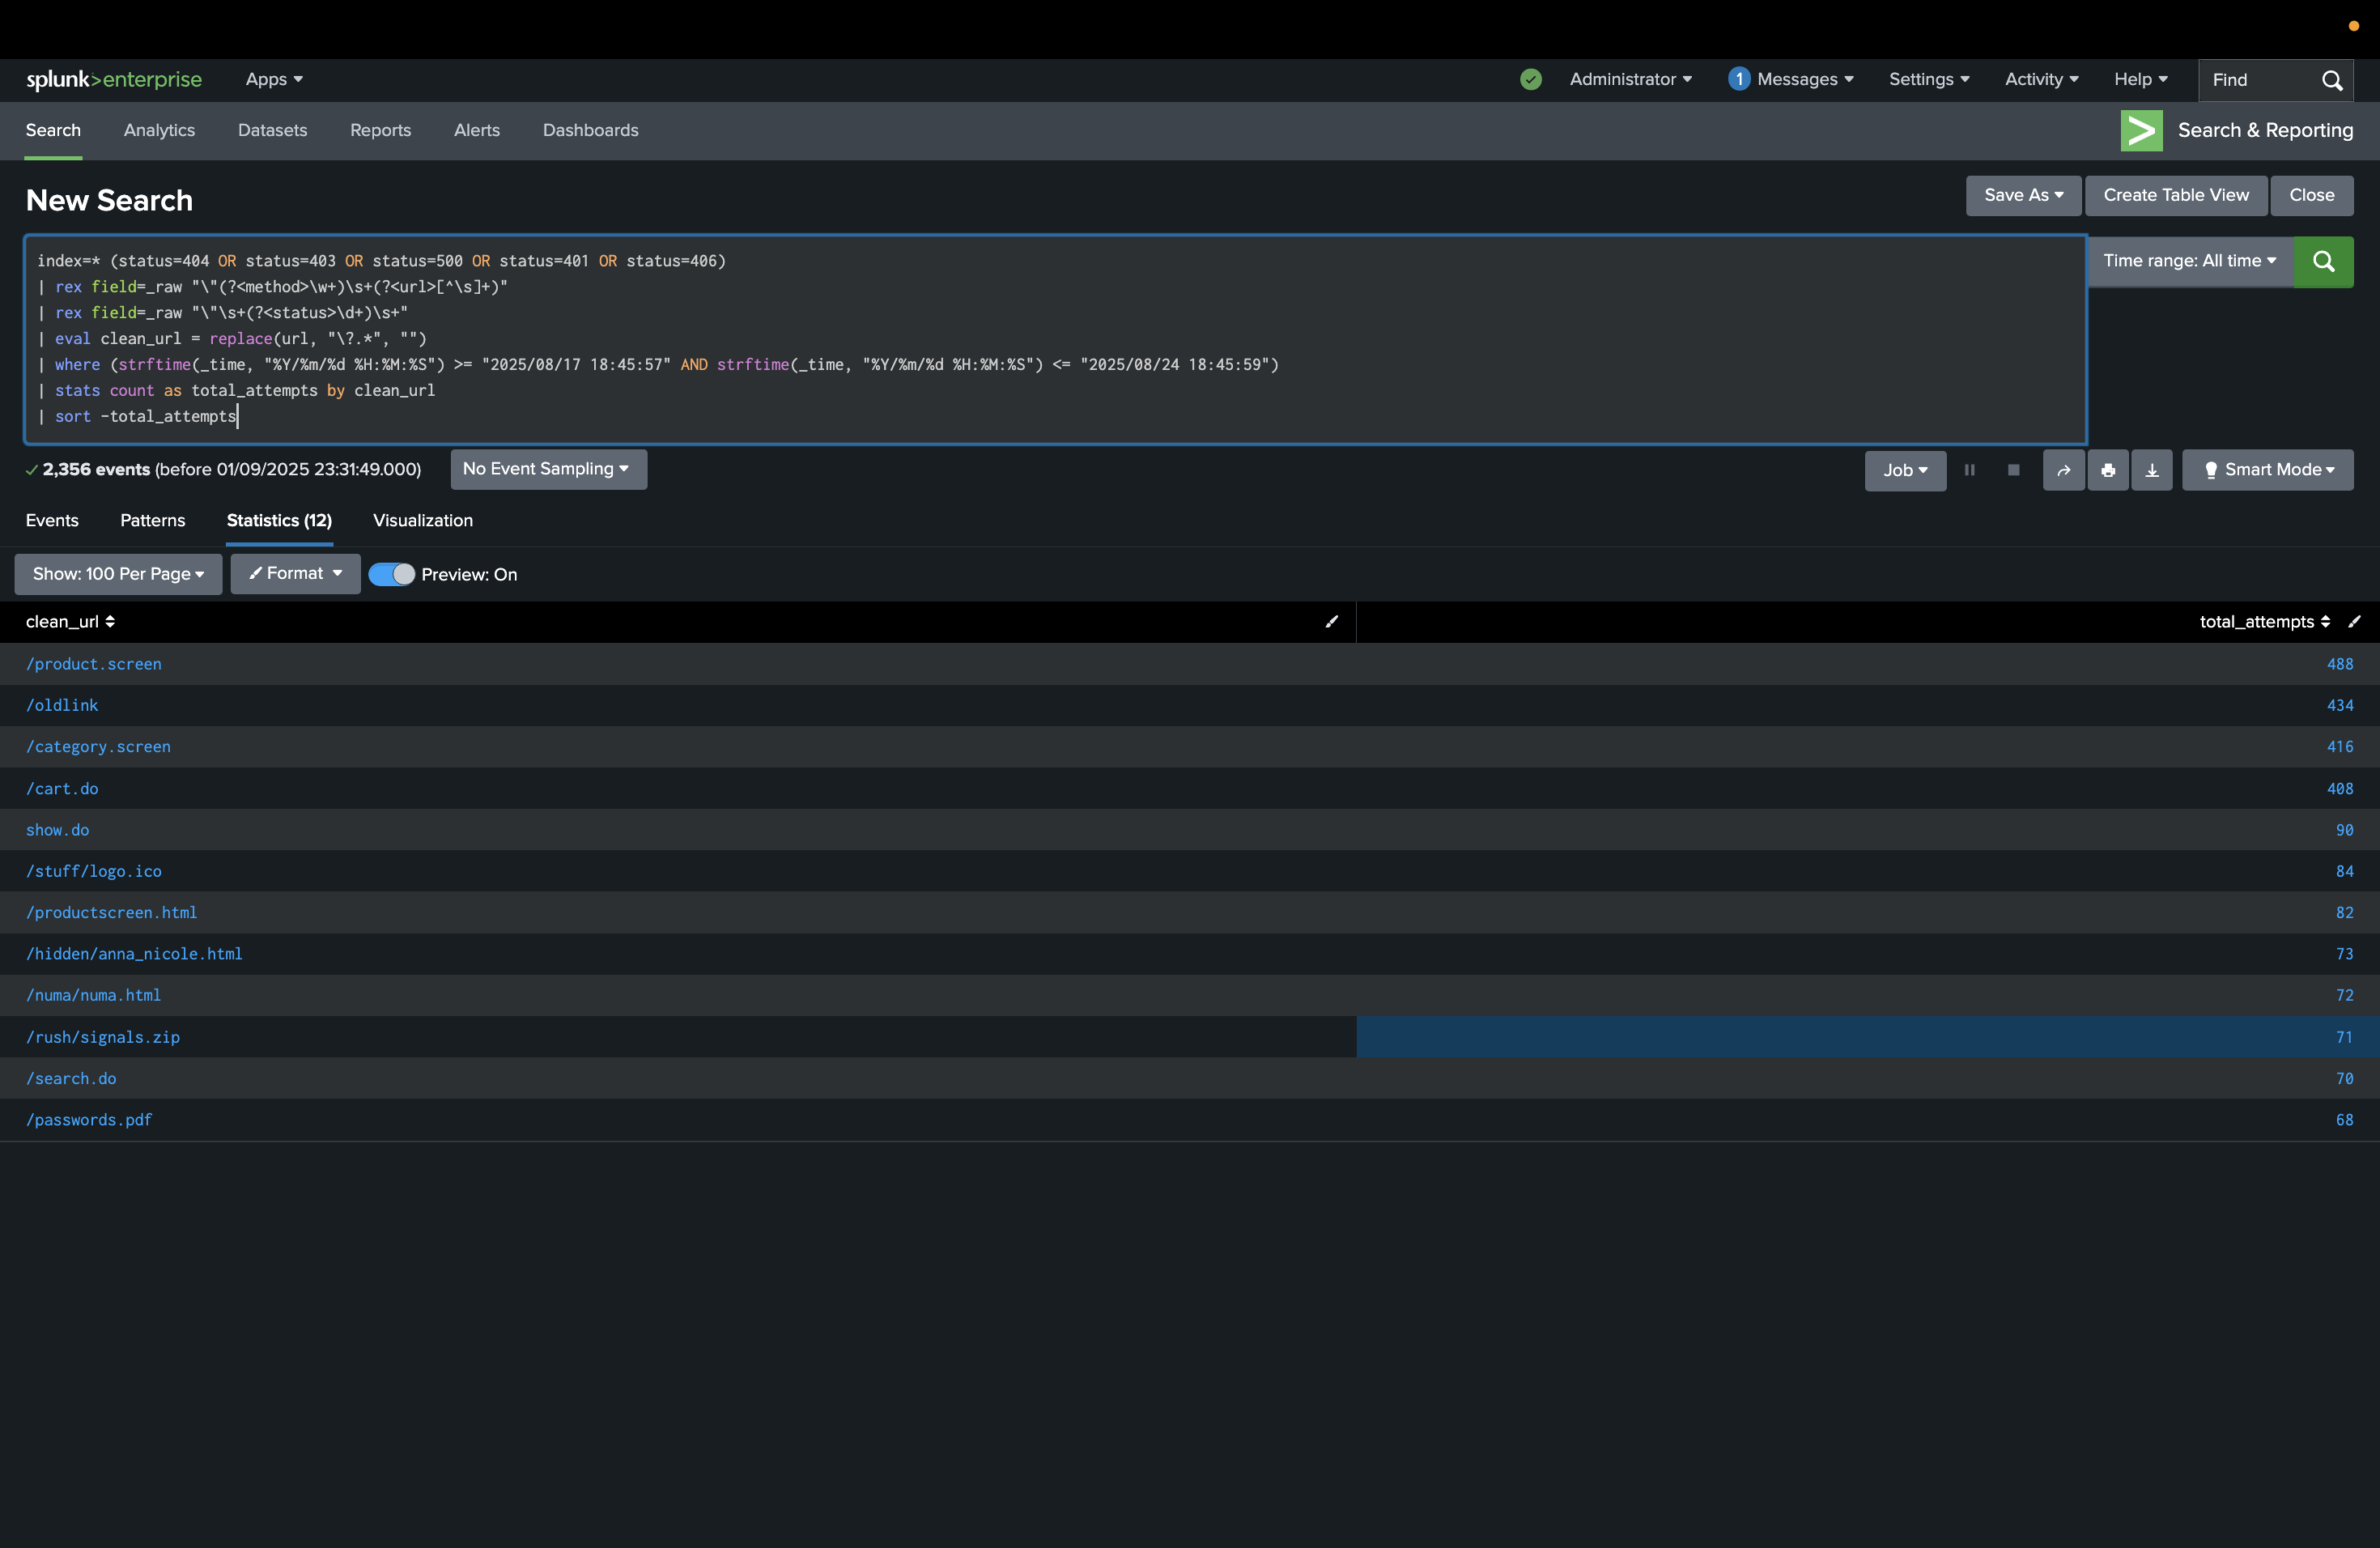

## Answer: 
#### The query searches web access logs for requests to potentially sensitive files by filtering suspicious file paths and extensions

#### - /hidden/anna_nicole.html (73 attempts) - hidden web content
#### - /rush/signals.zip (71 attempts) - compressed archive potentially containing valuable data
#### - /passwords.pdf (68 attempts) - document likely containing credential information

#### Total: 212 attempts

# Q6

## Answer:

#### - /hidden/anna_nicole.html
#### - /rush/signals.zip (71 attempts)
#### - /passwords.pdf (68 attempts)

#### Sensitive information attempts are identified by looking for files with names suggesting confidential data, hidden directories, or valuable archives
#### Attackers are systematically probing common sensitive file locations, indicating reconnaissance activity to find confidential documents and hidden content

# Q7: Can you find any bots crawling our websites?

In [ ]:
index=* (host=www1 OR host=www2 OR host=www3 OR *GET* OR *POST*) 
| rex field=_raw "\"(?<user_agent>[^\"]*)\"\s+\d+$"
| search user_agent="*bot*" OR user_agent="*crawler*" OR user_agent="*spider*" OR user_agent="*scraper*"
| stats count by user_agent
| sort -count

### The query searches web access logs from all three web servers (www1, www2, www3) and extracts User-Agent strings using regex
### Filters for bot-related keywords: "bot", "crawler", "spider", "scraper" to identify automated crawlers

## 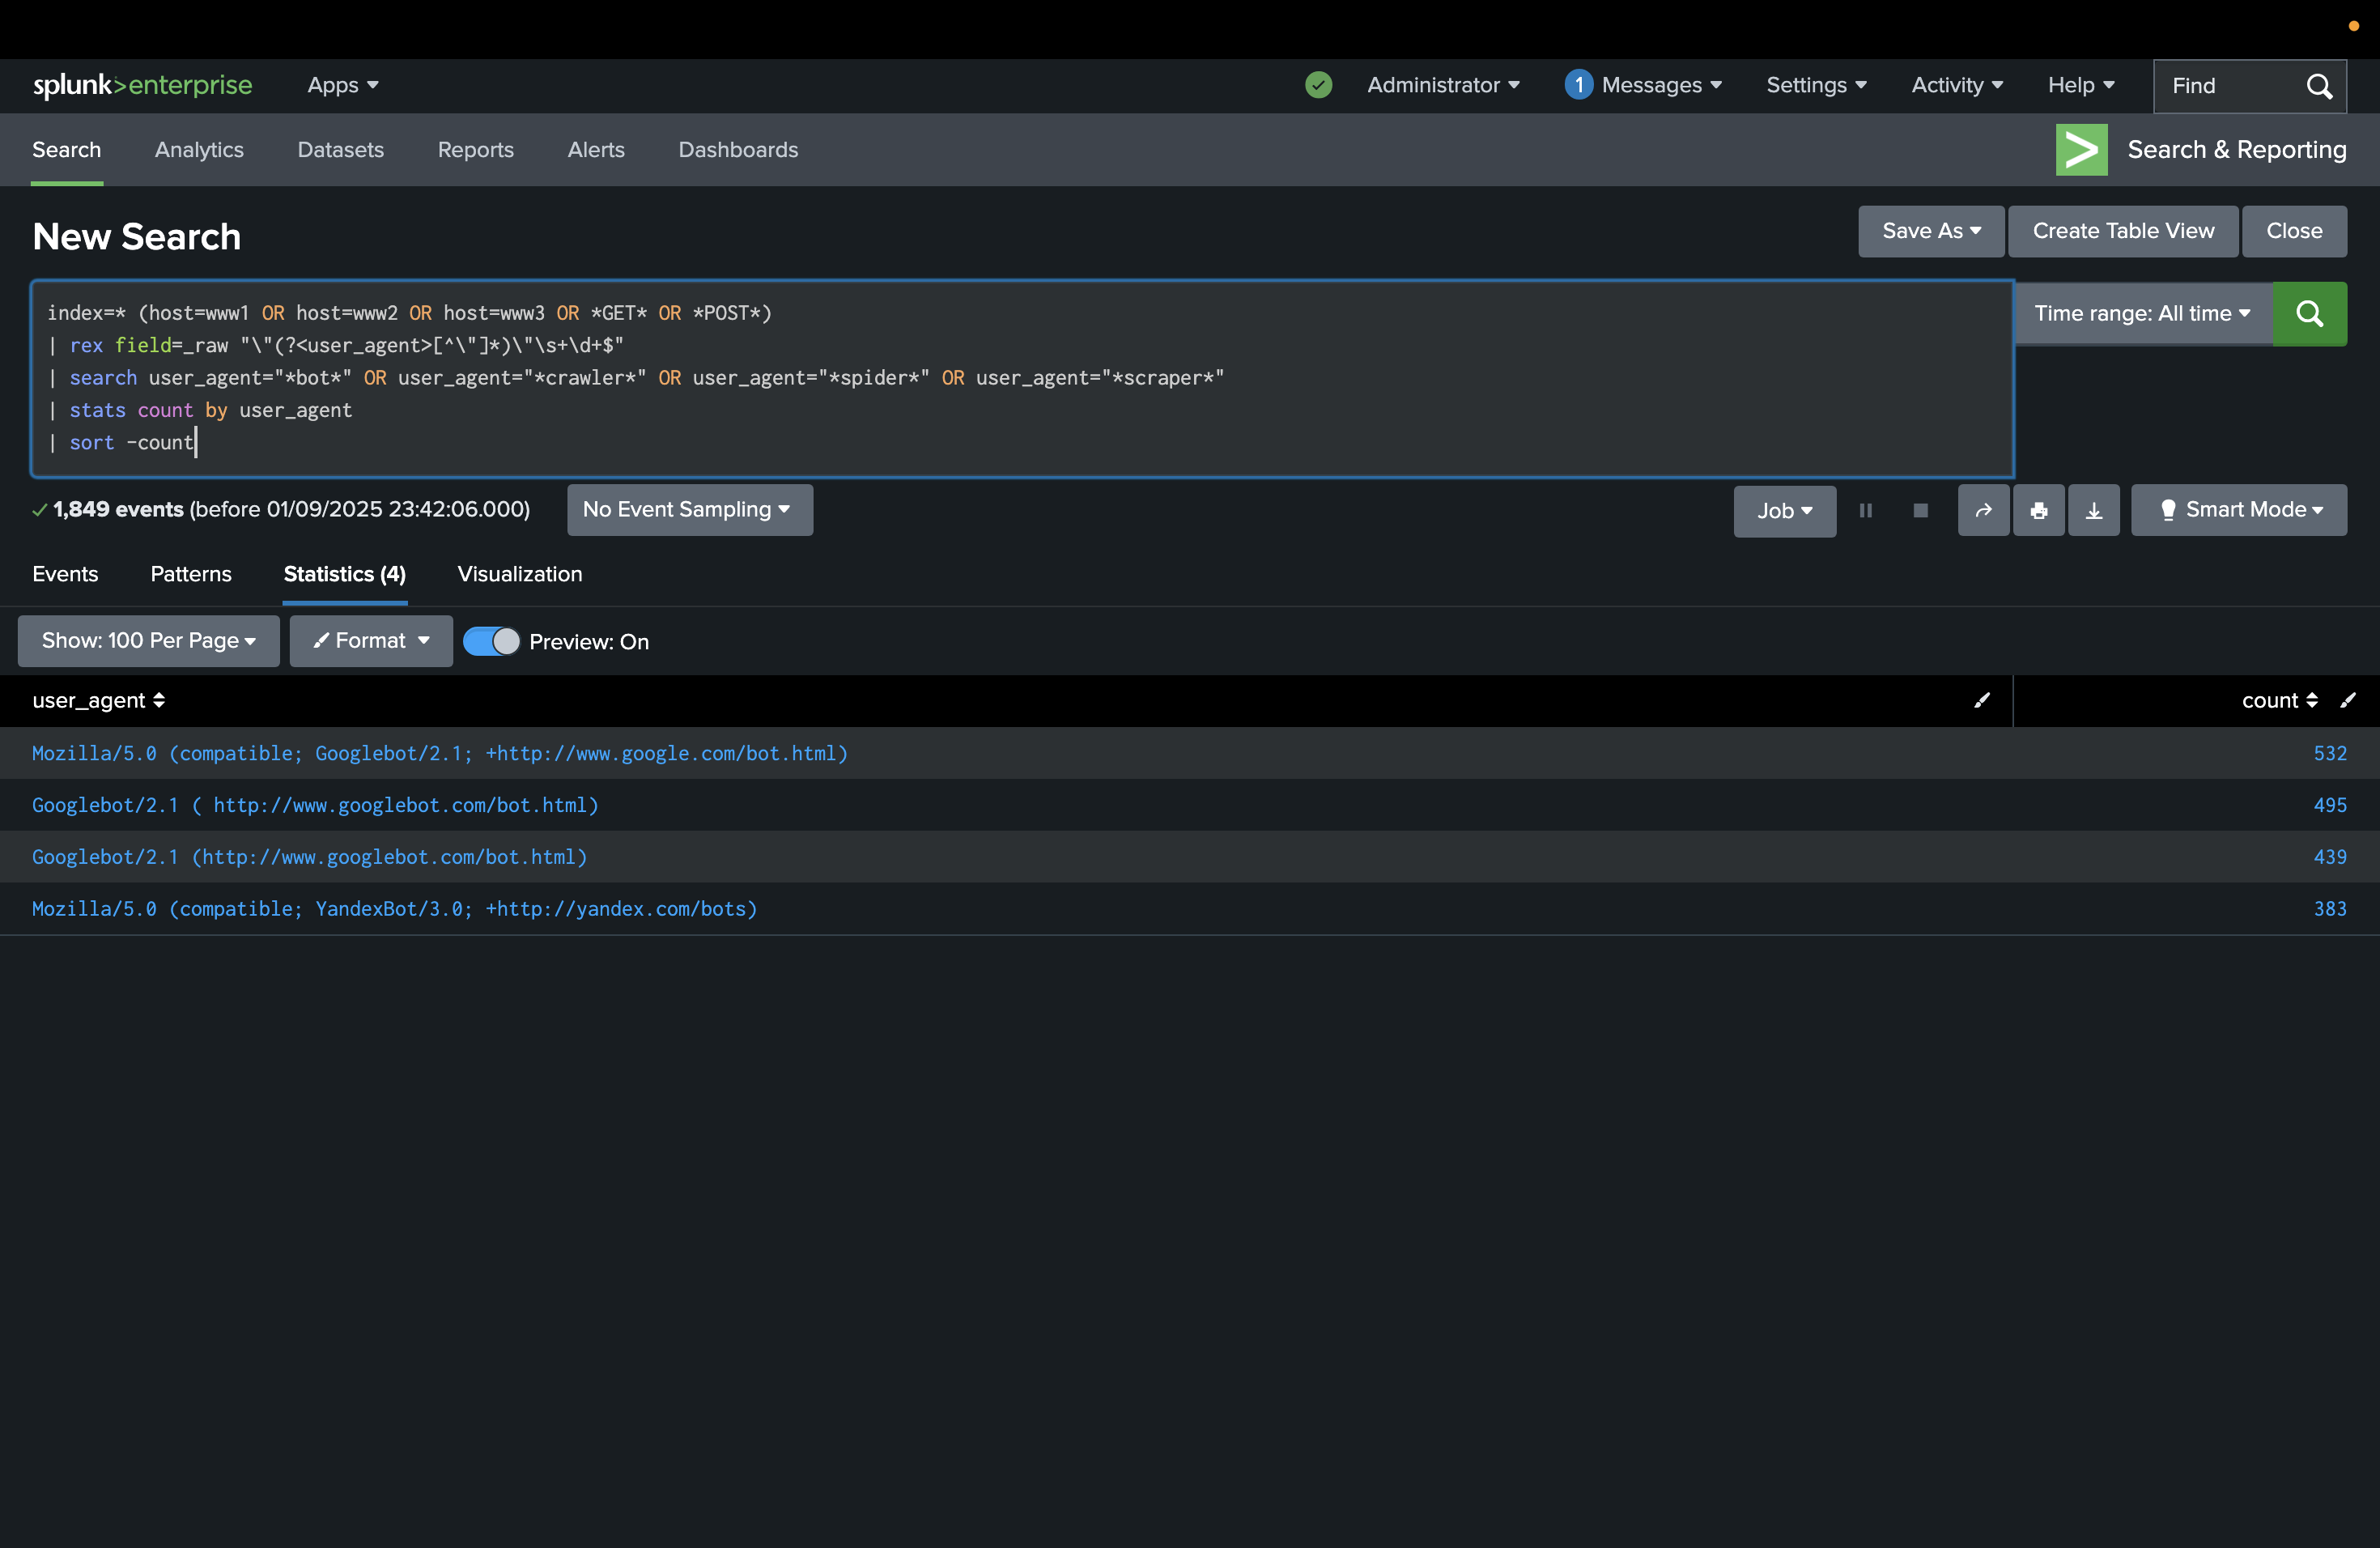

## Answer: 
#### Yes, the logs indicate the presence of bots crawling the website. The following user agents are associated with bot activity:

- `Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)`
- `Googlebot/2.1 (http://www.googlebot.com/bot.html)`
- `Mozilla/5.0 (compatible; YandexBot/3.0; +http://yandex.com/bots)`

#### These user agents contain keywords like "bot" and "crawler," confirming automated crawling activity on the web servers.

# Q8: What are they doing on the site? (Hint: Look for User-Agent in the web access.logs.)

In [ ]:
index=* (host=www1 OR host=www2 OR host=www3 OR *GET* OR *POST*) 
| rex field=_raw "\"(?<method>\w+)\s+(?<url>[^\s]+)" 
| rex field=_raw "\"(?<user_agent>[^\"]*)\"\s+\d+$"
| search user_agent="*bot*" OR user_agent="*crawler*" OR user_agent="*spider*" OR user_agent="*scraper*"
| eval clean_url = replace(url, "\?.*", "")
| stats count as requests by user_agent, clean_url
| sort user_agent, -requests

#### The query extracts URLs accessed by bots and shows their crawling patterns across the website

## 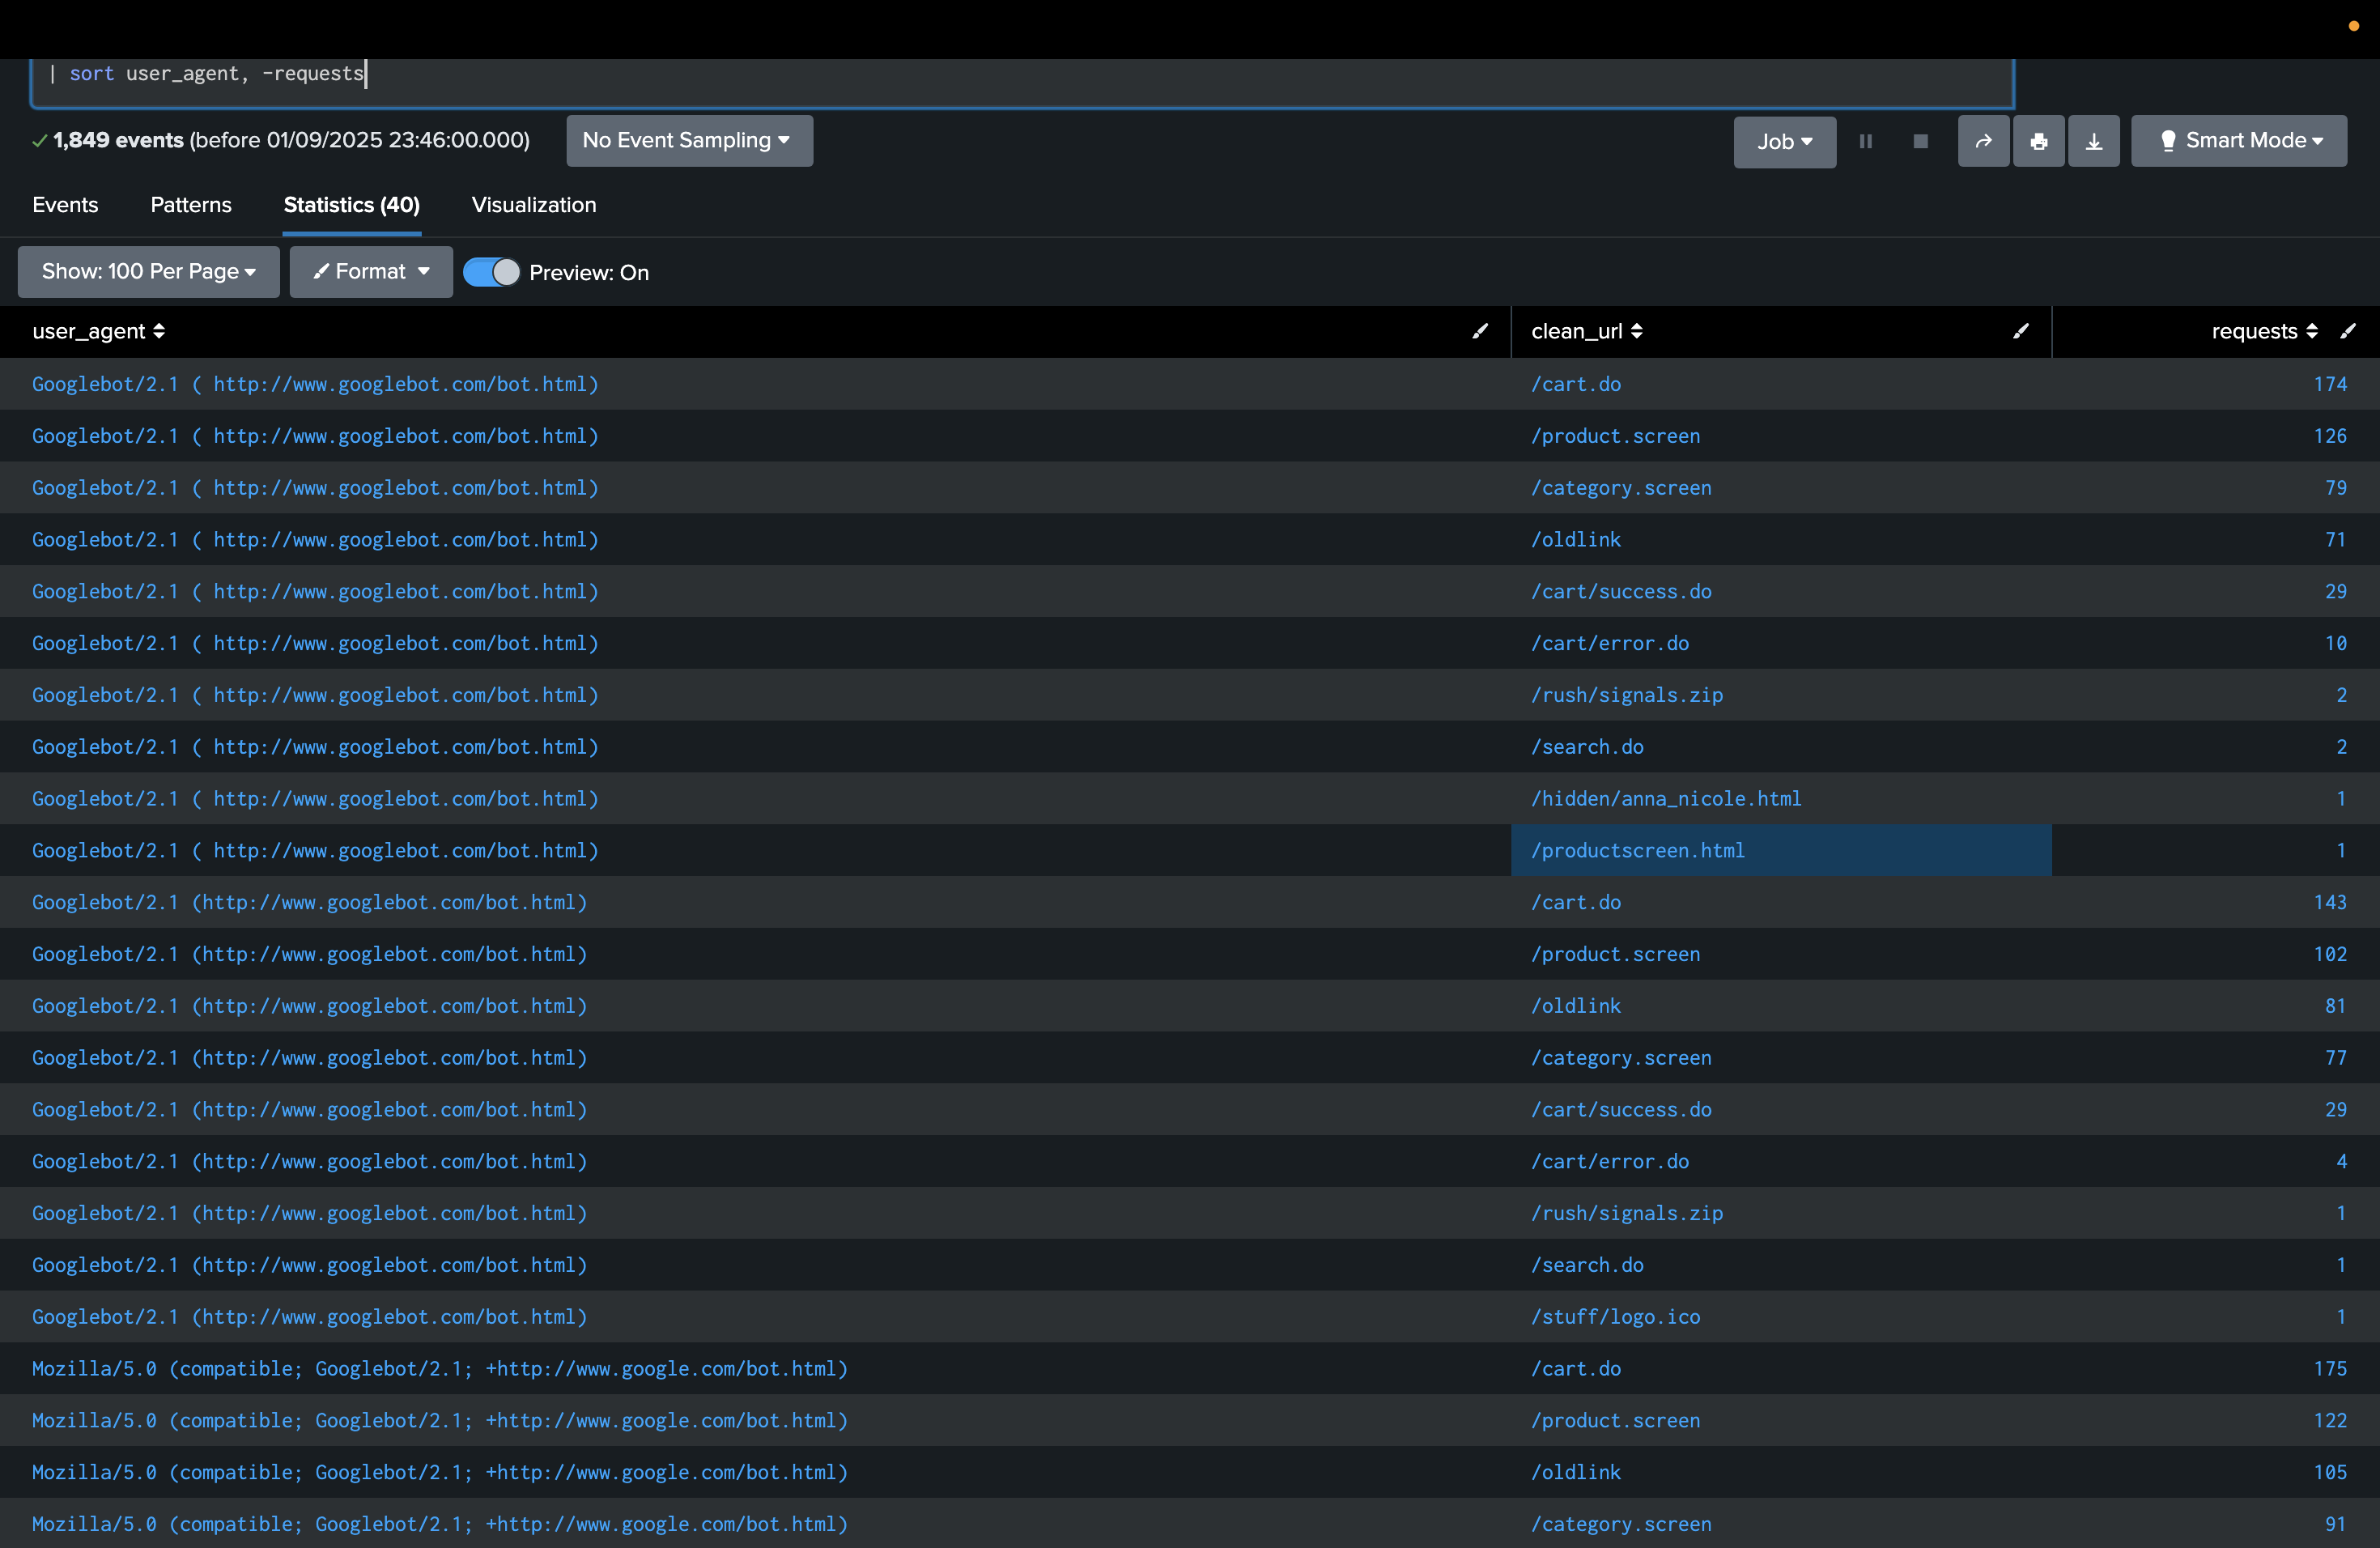

## Answer:


Bots primarily crawl e-commerce functionality:

- Shopping cart pages (/cart.do)
- Product pages (/product.screen, /category.screen)
- Cart success/error pages
    

Also accessing standard site elements:

- Old links (/oldlink)
- Search functionality (/search.do)
- Site assets (/stuff/logo.ico)


Bots discovered sensitive files from Q5/Q6:

- /rush/signals.zip
- /hidden/anna_nicole.html

# Chayanin Kongsareekul 6532035021